# PROMISE12 Prostate Segmentation

## Importing Libraries

Importing libraries to access directory, to load image, to use array, to plot, to process image, and generate random variables

In [1]:
%matplotlib inline
import os, os.path
import skimage.io as io
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from skimage.morphology import binary_erosion

Importing libraries for U-Net model

In [2]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Reshape
from keras.layers import Input, Activation
from keras.layers import Conv2D, AveragePooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization

from keras.optimizers import Adam
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint

C:\Users\Indri92\Anaconda3\envs\tfgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Functions to load images and labels (Resize all the 2D image to a fix resolution of 320x320

In [3]:
def loadImages (filename, plugin='simpleitk'):
    imagesArray=[];
    images=io.imread(filename,plugin=plugin)   
    #Resizing and stacking the slices
    for i in range(images.shape[0]):
        imagesArray.append(np.array(cv2.resize(images[i],(320,320), interpolation=cv2.INTER_AREA),dtype='int16'))
    return imagesArray


def loadImagesLabel (filename, plugin='simpleitk'):
    imagesArray=[];
    images=io.imread(filename,plugin=plugin)   
    #Resizing and stacking the slices
    for i in range(images.shape[0]):
        imagesArray.append(np.array(cv2.resize(images[i],(320,320), interpolation=cv2.INTER_NEAREST),'int8'))
    return imagesArray#,spacing

## Creating a plotting function

In [4]:
def plottingWithRedLabel (x,y):
    #Normalising the x data to 0 to 255 
    x=np.array((x-x.min())/(x.max()-x.min())*255,'uint8')
    #Creating the border of the segmentation
    yEroded=binary_erosion(y,np.ones((5,5)))
    yBorder=np.logical_xor(y,yEroded)
    #Clip the red channel value
    xy=np.clip(x+yBorder*255,0,255)
    return np.stack([xy,x,x], axis=-1)

## Training data preparation (defining the file index for training, validation and testing files)

In [5]:
completeFiles=['00','01','02','03','04','05','06','07','08','09']
for i in range(10,50):completeFiles.append(str(i))
validationFiles=['00','09']
trainingFiles=completeFiles.copy()
for i in range(len(validationFiles)): trainingFiles.remove(validationFiles[i]) 
testingFiles=completeFiles[:30]

In [6]:
print('Training files index are ' + str(trainingFiles))

Training files index are ['01', '02', '03', '04', '05', '06', '07', '08', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']


In [7]:
print('Validation files index are '+str(validationFiles))

Validation files index are ['00', '09']


In [8]:
print('Testing files index are '+str(testingFiles))

Testing files index are ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29']


## Loading training and validation files 

In [9]:
trainPath=os.getcwd()+'//TrainData//'
xTrain=[];yTrain=[]
for trainIdx in range(len(trainingFiles)):
    xTrain.extend(loadImages(trainPath+'Case'+trainingFiles[trainIdx]+'.mhd'))
    yTrain.extend(loadImagesLabel(trainPath+'Case'+trainingFiles[trainIdx]+'_segmentation.mhd'))

#Getting the training mean and standard deviation
xTrainMean=np.array(xTrain).mean()
xTrainStd=np.array(xTrain).std()

xVal=[];yVal=[]
for valIdx in range(len(validationFiles)):
    xVal.extend(loadImages(trainPath+'Case'+validationFiles[valIdx]+'.mhd'))
    yVal.extend(loadImagesLabel(trainPath+'Case'+validationFiles[valIdx]+'_segmentation.mhd'))

#Centering the training and validation data
xTrain=np.array(xTrain)-xTrainMean
xVal=np.array(xVal)-xTrainMean

Plotting the 2D image and labels (random slides)

[134, 355, 1213]


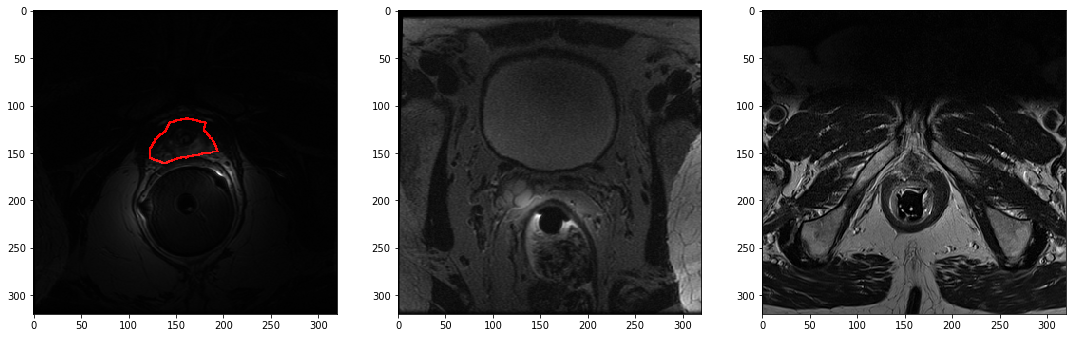

In [10]:
idx=random.sample(range(len(xTrain)),3)
print(idx)
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
fig.set_size_inches(18.5,10.5)
ax1.imshow(plottingWithRedLabel(xTrain[idx[0]],yTrain[idx[0]]))
ax2.imshow(plottingWithRedLabel(xTrain[idx[1]],yTrain[idx[1]]))
ax3.imshow(plottingWithRedLabel(xTrain[idx[2]],yTrain[idx[2]]))

# Building and training the model

In [11]:
#IA-UNet
inputs = Input((320, 320,1))
inputsNormed=BatchNormalization()(inputs)
conv1a = Conv2D(16, 3, padding = 'same', kernel_initializer = 'he_normal')(inputsNormed)
conv1a = BatchNormalization()(conv1a)
conv1a = Activation('relu')(conv1a)
conv1b = Conv2D(16, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1a)
conv1b = BatchNormalization()(conv1b)
conv1b = Activation('relu')(conv1b)
conv1Res1 = keras.layers.Concatenate()([conv1a,conv1b])
pool1 = AveragePooling2D(pool_size=(2, 2))(conv1Res1)

conv2a = Conv2D(32, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2a = BatchNormalization()(conv2a)
conv2a = Activation('relu')(conv2a)
conv2b = Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2a)
conv2b = BatchNormalization()(conv2b)
conv2b = Activation('relu')(conv2b)
conv2Res1 = keras.layers.Concatenate()([conv2a,conv2b])
pool2 = AveragePooling2D(pool_size=(2, 2))(conv2Res1)


conv3a = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3a = BatchNormalization()(conv3a)
conv3a = Activation('relu')(conv3a)
conv3b = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3a)
conv3b = BatchNormalization()(conv3b)
conv3b = Activation('relu')(conv3b)
conv3Res1 = keras.layers.Concatenate()([conv3a,conv3b])
pool3 = AveragePooling2D(pool_size=(2, 2))(conv3Res1)

conv4a = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4a = BatchNormalization()(conv4a)
conv4a = Activation('relu')(conv4a)
conv4b = Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal')(conv4a)
conv4b = BatchNormalization()(conv4b)
conv4b = Activation('relu')(conv4b)
conv4Res1 = keras.layers.Concatenate()([conv4a,conv4b])
drop4 = Dropout(0.5)(conv4Res1)
pool4 = AveragePooling2D(pool_size=(2, 2))(drop4)

conv5a = Conv2D(256, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5a = BatchNormalization()(conv5a)
conv5a = Activation('relu')(conv5a)
conv5b = Conv2D(256, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv5a)
conv5b = BatchNormalization()(conv5b)
conv5b = Activation('relu')(conv5b)
conv5Res1 = keras.layers.Concatenate()([conv5a,conv5b])
drop5 = Dropout(0.5)(conv5Res1)

up6 = Conv2D(128, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
up6 = BatchNormalization()(up6)
up6 = Activation('relu')(up6)
merge6 = keras.layers.Concatenate()([conv4Res1,up6])
conv6a = Conv2D(128, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6a = BatchNormalization()(conv6a)
conv6a = Activation('relu')(conv6a)
conv6b = Conv2D(128, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv6a)
conv6b = BatchNormalization()(conv6b)
conv6b = Activation('relu')(conv6b)
conv6Res1 = keras.layers.Concatenate()([conv6a,conv6b])

up7 = Conv2D(64, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6Res1))
up7 = BatchNormalization()(up7)
up7 = Activation('relu')(up7)
merge7 = keras.layers.Concatenate()([conv3Res1,up7])
conv7a = Conv2D(64, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7a = BatchNormalization()(conv7a)
conv7a = Activation('relu')(conv7a)
conv7b = Conv2D(64, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv7a)
conv7b = BatchNormalization()(conv7b)
conv7b = Activation('relu')(conv7b)
conv7Res1 = keras.layers.Concatenate()([conv7a,conv7b])

up8 = Conv2D(32, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7Res1))
up8 = BatchNormalization()(up8)
up8 = Activation('relu')(up8)
merge8 = keras.layers.Concatenate()([conv2Res1,up8])
conv8a = Conv2D(32, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8a = BatchNormalization()(conv8a)
conv8a = Activation('relu')(conv8a)
conv8b = Conv2D(32, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv8a)
conv8b = BatchNormalization()(conv8b)
conv8b = Activation('relu')(conv8b)
conv8Res1 = keras.layers.Concatenate()([conv8a,conv8b])

up9 = Conv2D(16, 2,  padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8Res1))
up9 = BatchNormalization()(up9)
up9 = Activation('relu')(up9)
merge9 = keras.layers.Concatenate()([conv1Res1,up9])
conv9a = Conv2D(16, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9a = BatchNormalization()(conv9a)
conv9a = Activation('relu')(conv9a)
conv9b = Conv2D(16, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9a)
conv9b = BatchNormalization()(conv9b)
conv9b = Activation('relu')(conv9b)
conv9Res1 = keras.layers.Concatenate()([conv9a,conv9b])
conv9 = Conv2D(2, 3,  padding = 'same', kernel_initializer = 'he_normal')(conv9Res1)
conv9 = BatchNormalization()(conv9)
conv9 = Activation('relu')(conv9)
conv10 = Conv2D(1, 1)(conv9)
conv10 = BatchNormalization()(conv10)
conv10 = Activation('sigmoid')(conv10)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 320, 320, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 16) 160         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 320, 320, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

C:\Users\Indri92\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Setting save path, checkpoints, calculating class_weights, fitting the model without augmentation

In [12]:
savePath=os.getcwd()+'//Models//' 
   
checkpoint= ModelCheckpoint(savePath+'PROMISE12_IA-{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss',verbose=1, save_best_only=False,mode='auto')
callbacks_list = [checkpoint]
class_weights = class_weight.compute_class_weight('balanced',
                                             np.unique(yTrain),
                                             np.ravel(yTrain))
history=model.fit((np.array(xTrain)/xTrainStd).reshape(-1,320,320,1), np.array(yTrain).reshape(-1,320,320,1), batch_size=3, epochs=150, callbacks=callbacks_list,verbose=1,shuffle=True,class_weight=class_weights,validation_data=((np.array(xVal)/xTrainStd).reshape(-1,320,320,1),np.array(yVal).reshape(-1,320,320,1)) )   

Train on 1283 samples, validate on 94 samples
Epoch 1/150
1283/1283 [==============================] - 75s 59ms/step - loss: 0.6969 - acc: 0.5019 - val_loss: 0.7338 - val_acc: 0.2145

Epoch 00001: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-01-0.73.h5
Epoch 2/150
1283/1283 [==============================] - 64s 50ms/step - loss: 0.6677 - acc: 0.7265 - val_loss: 0.6965 - val_acc: 0.7014

Epoch 00002: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-02-0.70.h5
Epoch 3/150
1283/1283 [==============================] - 64s 50ms/step - loss: 0.6439 - acc: 0.8427 - val_loss: 0.6517 - val_acc: 0.8604

Epoch 00003: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-03-0.65.h5
Epoch 4/150
1283/1283 [==============================] - 64s 50ms/step - loss: 0.6194 - acc: 0.8893 - val_loss: 0.6549 - val_acc: 0.8761

Epoch 00004: saving model to D:\UniData\Zip Folders\PROMISE12_Jupyter

Epoch 34/150
1283/1283 [==============================] - 66s 52ms/step - loss: 0.2016 - acc: 0.9965 - val_loss: 0.2205 - val_acc: 0.9924

Epoch 00034: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-34-0.22.h5
Epoch 35/150
1283/1283 [==============================] - 67s 52ms/step - loss: 0.1929 - acc: 0.9972 - val_loss: 0.2035 - val_acc: 0.9933

Epoch 00035: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-35-0.20.h5
Epoch 36/150
1283/1283 [==============================] - 67s 52ms/step - loss: 0.1846 - acc: 0.9976 - val_loss: 0.2034 - val_acc: 0.9933

Epoch 00036: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-36-0.20.h5
Epoch 37/150
1283/1283 [==============================] - 65s 51ms/step - loss: 0.1797 - acc: 0.9970 - val_loss: 0.1836 - val_acc: 0.9927

Epoch 00037: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-37-0.18.h5


Epoch 67/150
1283/1283 [==============================] - 64s 50ms/step - loss: 0.0557 - acc: 0.9984 - val_loss: 0.0733 - val_acc: 0.9945

Epoch 00067: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-67-0.07.h5
Epoch 68/150
1283/1283 [==============================] - 65s 50ms/step - loss: 0.0531 - acc: 0.9986 - val_loss: 0.0743 - val_acc: 0.9947

Epoch 00068: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-68-0.07.h5
Epoch 69/150
1283/1283 [==============================] - 65s 50ms/step - loss: 0.0512 - acc: 0.9986 - val_loss: 0.0788 - val_acc: 0.9939

Epoch 00069: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-69-0.08.h5
Epoch 70/150
1283/1283 [==============================] - 65s 50ms/step - loss: 0.0497 - acc: 0.9986 - val_loss: 0.0729 - val_acc: 0.9943

Epoch 00070: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-70-0.07.h5


Epoch 100/150
1283/1283 [==============================] - 63s 49ms/step - loss: 0.0160 - acc: 0.9990 - val_loss: 0.0365 - val_acc: 0.9947

Epoch 00100: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-100-0.04.h5
Epoch 101/150
1283/1283 [==============================] - 63s 49ms/step - loss: 0.0152 - acc: 0.9991 - val_loss: 0.0467 - val_acc: 0.9943

Epoch 00101: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-101-0.05.h5
Epoch 102/150
1283/1283 [==============================] - 63s 49ms/step - loss: 0.0146 - acc: 0.9991 - val_loss: 0.0435 - val_acc: 0.9945

Epoch 00102: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-102-0.04.h5
Epoch 103/150
1283/1283 [==============================] - 63s 49ms/step - loss: 0.0143 - acc: 0.9991 - val_loss: 0.0427 - val_acc: 0.9945

Epoch 00103: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-103-


Epoch 00132: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-132-0.03.h5
Epoch 133/150
1283/1283 [==============================] - 63s 49ms/step - loss: 0.0052 - acc: 0.9994 - val_loss: 0.0333 - val_acc: 0.9947

Epoch 00133: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-133-0.03.h5
Epoch 134/150
1283/1283 [==============================] - 63s 49ms/step - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0345 - val_acc: 0.9948

Epoch 00134: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-134-0.03.h5
Epoch 135/150
1283/1283 [==============================] - 63s 49ms/step - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0302 - val_acc: 0.9950

Epoch 00135: saving model to D:\UniData\Zip Folders\PROMISE12_JupyterNotebook//Models//PROMISE12_IA-135-0.03.h5
Epoch 136/150
1283/1283 [==============================] - 63s 49ms/step - loss: 0.0047 - acc: 0.9994 - val_loss: 0.0338 - val_acc:

# Plot training and validation history

<function matplotlib.pyplot.show(*args, **kw)>

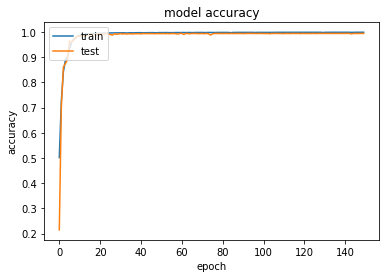

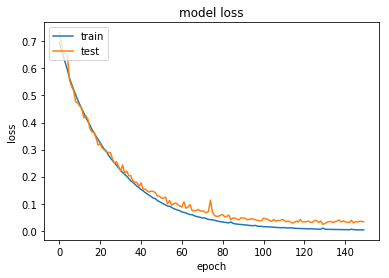

In [13]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show

## Producing segmentation on the test set

In [14]:
testPath=os.getcwd()+'//TestData//'
savePath=os.getcwd()+'//TestingResults//' 
for fileIdx in range(len(testingFiles)):
    mhd = sitk.ReadImage(testPath+'Case'+testingFiles[fileIdx]+'.mhd')
    mhdSize = sitk.GetArrayFromImage(mhd).shape
    origin = mhd.GetOrigin()
    spacing = mhd.GetSpacing()
    direction = mhd.GetDirection()
    
    
    xTest=[];yTest=[]
    xTest.extend(loadImages(testPath+'Case'+testingFiles[fileIdx]+'.mhd'))
            
    xTest=np.array(xTest)-xTrainMean

    predList=[]
    for idx in range(len(xTest)):
        pred=model.predict(np.resize(np.array(xTest[idx])/xTrainStd,(1,320,320,1)))
        predList.append(pred[0,:,:,0]>0.5)
        
    predListResized=[]
    for idx in range(len(xTest)):
        predListResized.append(np.array(cv2.resize(np.array(predList[idx],'int8'),mhdSize[1:], interpolation=cv2.INTER_NEAREST),'int8'))
        
    toMhd=sitk.GetImageFromArray(np.array(predListResized,'int8'))
    toMhd.SetOrigin( origin )
    toMhd.SetDirection( direction )
    toMhd.SetSpacing( spacing )
    sitk.WriteImage(toMhd, savePath+'Case'+testingFiles[fileIdx]+'_segmentation.mhd')     
      
    

## Loading the results

In [15]:
xTest=[];yTest=[]
for testIdx in range(len(testingFiles)):
    xTest.extend(loadImages(testPath+'Case'+testingFiles[testIdx]+'.mhd'))
    yTest.extend(loadImagesLabel(savePath+'Case'+testingFiles[testIdx]+'_segmentation.mhd'))

## Plotting the results

[352, 367, 454]


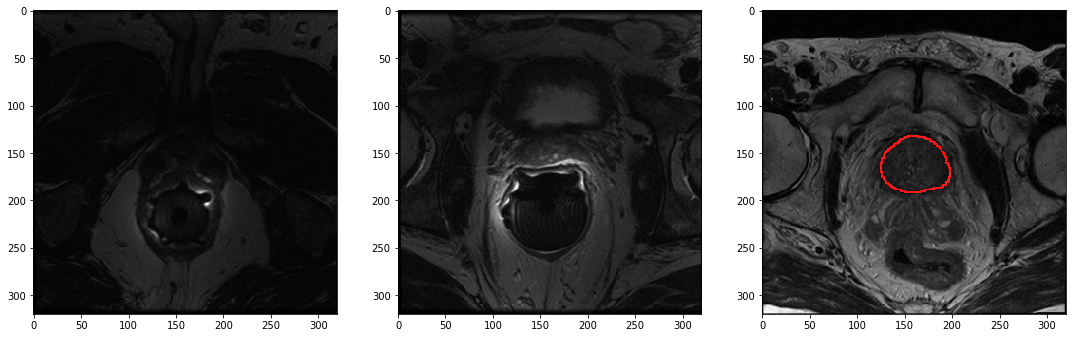

In [16]:
idx=random.sample(range(len(xTest)),3)
print(idx)
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
fig.set_size_inches(18.5,10.5)
ax1.imshow(plottingWithRedLabel(xTest[idx[0]],yTest[idx[0]]))
ax2.imshow(plottingWithRedLabel(xTest[idx[1]],yTest[idx[1]]))
ax3.imshow(plottingWithRedLabel(xTest[idx[2]],yTest[idx[2]]))

Details on the results can be seen on the PROMISE12 challenge leaderboard (Indri92)